In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import matplotlib.animation as animation

In [59]:
X_0 = np.random.rand(20,2) + 1
X_1 = np.random.rand(20,2) - 1
X = np.concatenate([X_0, X_1])
#np.random.shuffle(X)

In [60]:
def L2_dist(a, b):
    return np.linalg.norm(a-b)

In [61]:
def compute_G0(X, d=L2_dist):
    W = np.zeros((len(X), len(X)))
    for i in range(len(X)-1):
        for j in range(i+1, len(X)):
            W[i, j] = d(X[i], X[j])
            W[j, i] = d(X[i], X[j])
    D_sqinv = np.diag(np.sum(W, axis=0) ** -0.5)
    return W, D_sqinv

In [62]:
W, D_sqinv = compute_G0(X)

In [63]:
def compute_laplacian(W, D_sqinv):
    return np.eye(len(W)) - D_sqinv @ W @ D_sqinv

In [64]:
L = compute_laplacian(W, D_sqinv)

In [65]:
def compute_AM_normalised(L, D_sqinv, M=len(L)):
    V, A = np.linalg.eig(L)
    V = 1 - V
    idx = V.argsort()  
    V = V[idx]
    A = A[:,idx]
    V = np.diag(V)
    A = A[:, :M]
    return D_sqinv @ A

In [66]:
A = compute_AM_normalised(L, D_sqinv, 3)

In [86]:
class Graph:
    def __init__(self, vertices):
        self.V = vertices
        self.graph = []
        self.hierarchy = None
        self.A = None

    def add_edge(self, u, v, w):
        self.graph.append([u, v, w])

    # Search function, ça trouve un point fixe en fait, en partant de celui qu'on veut

    def find(self, parent, i):
        if parent[i] == i:
            return i
        return self.find(parent, parent[i])

    def apply_union(self, parent, rank, x, y):
        xroot = self.find(parent, x)
        yroot = self.find(parent, y)
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

    #  Applying Kruskal algorithm
    def kruskal_algo(self):
        result = []
        hierarchy = []
        i, e = 0, 0
        self.graph = sorted(self.graph, key=lambda item: item[2])
        rank = [0] * self.V
        parent = list(range(self.V))
        while e < self.V - 1:
            u, v, w = self.graph[i]
            i += 1
            x = self.find(parent, u)
            y = self.find(parent, v)
            if x != y:
                e += 1
                result.append([u, v, w])
                self.apply_union(parent, rank, x, y)
                hierarchy.append(result.copy())
        self.hierarchy = hierarchy
        return hierarchy
            
        
    def compute_A(self):
        A = np.zeros((g.V, g.V))
        for e in g.graph:
            A[e[0], e[1]] = e[2]
            A[e[1], e[0]] = e[2]
        self.A = A

    def cross_sum(self, A, l1, l2):
        return np.sum((A * l1).T * l2)
    
    
    def compute_mat(self):
        A = self.A
        mat = np.zeros((2 * self.V - 1, self.V + 6))
        for i in range(self.V):
            mat[i, 5] = 1
            mat[i, i + 6] = 1
        hierarchy = self.hierarchy
        l_buf = list(range(self.V))
        for i, e in enumerate(hierarchy[-1]):
            u, v, _ = e
            j = i + self.V
            mat[l_buf[u], 0] = j
            mat[l_buf[v], 0] = j
            mat[l_buf[u], 1] = l_buf[v]
            mat[l_buf[v], 1] = l_buf[u]
            mat[j, 2] = l_buf[u]
            mat[j, 3] = l_buf[v]
            mat[j, 4:] = mat[l_buf[u], 4:] + mat[l_buf[v], 4:]
            mat[j, 4] += self.cross_sum(A, mat[l_buf[u], 6:], mat[l_buf[v], 6:])
            for k in range(self.V):
                if mat[j, k + 6]:
                    l_buf[k] = j
        return mat

In [87]:
g = Graph(4)
#g.add_edge(0, 1, 4)
#g.add_edge(0, 2, 1)
#g.add_edge(0, 3, 2)
#g.add_edge(1, 2, 5)
#g.add_edge(1, 3, 3)
#g.add_edge(2, 3, 8)
g.add_edge(0, 1, 8)
g.add_edge(0, 2, 6)
g.add_edge(0, 3, 1)
g.add_edge(1, 2, 2)
g.add_edge(1, 3, 5)
g.add_edge(2, 3, 4)



g.compute_A()
g.kruskal_algo()
g.compute_mat()

array([[ 4.,  3.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 5.,  2.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.],
       [ 5.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.],
       [ 4.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.],
       [ 6.,  5.,  0.,  3.,  1.,  2.,  1.,  0.,  0.,  1.],
       [ 6.,  4.,  1.,  2.,  2.,  2.,  0.,  1.,  1.,  0.],
       [ 0.,  0.,  5.,  4., 26.,  4.,  1.,  1.,  1.,  1.]])

In [69]:
def compute_Ge(A, d=L2_dist):
    g = Graph(len(A))
    W = np.zeros((len(A), len(A)))
    for i in range(len(A)-1):
        for j in range(i+1, len(A)):
            W[i, j] = d(A[i], A[j])
            W[j, i] = d(A[i], A[j])
            g.add_edge(i, j, d(A[i], A[j]))
    return W, g

In [70]:
W, g = compute_Ge(A)

In [74]:
g.compute_A()
g.kruskal_algo()
mat = g.compute_mat()

In [77]:
mat

array([[66.        , 13.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [41.        ,  9.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [53.        ,  4.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [78.        , 77.        ,  7.53887491, ...,  0.        ,
         0.        ,  0.        ],
       [78.        , 76.        ,  5.6255122 , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.        ,  0.        , 34.95635692, ...,  1.        ,
         1.        ,  1.        ]])

In [78]:
MM = np.zeros((2 * g.V - 1, 3))
for i in range(g.V):
    MM[i, 0] = True
    MM[i, 1] = i
    MM[i, 2] = 1e8
for i in range(g.V + 1, 2 * g.V):
    if mat[i, 4] / mat[i, 5] < MM[mat[i, 2], 2] and mat[i, 4] / mat[i, 5] < MM[mat[i, 3], 2]:
        MM[i, 0] = True
        MM[i, 1] = i
        MM[i, 2] = mat[i, 4] / mat[i, 5]
        MM[mat[i, 2], 0] = False
        MM[mat[i, 3], 0] = False

40

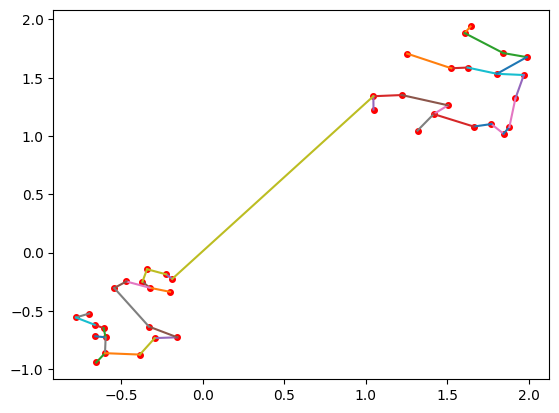

In [73]:
#a = np.random.rand(10,10)

fig, ax=plt.subplots()
container = []

ax.plot(X[:,0], X[:,1], 'ro',markersize=4)
#for v in hierarchy:
#    plt.plot(X[v[-1][0],0], X[v[-1][1],1])
#    plt.pause(0.01)

for v in hierarchy:
    line, = ax.plot(X[v[-1][:2]][:,0], X[v[-1][:2]][:,1])
    if len(container) > 0:
        container.append(container[-1] + [line])
    else: 
        container.append([line])
ani = animation.ArtistAnimation(fig, container, interval=400, blit=False)

writergif = animation.PillowWriter(fps=10)
ani.save('filename.gif',writer=writergif)

plt.show()